In [318]:
import pyreadr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import shap


In [8]:
data_path = 'df_gene_selected_lasso.csv'
df_er = pd.read_csv(data_path)
df_er

SKP1A      DHCR7      EPHB4        ADM   KIAA0040   C1orf123  \
0    10.950684  10.494364  10.348075  12.378857   8.531358   9.961502   
1    11.524726   8.961490   9.688557   7.871138   9.413448   9.702861   
2    10.631518  10.053360  10.336838   9.489243   8.160630   9.648145   
3    11.620446   9.732431   9.676061   7.846630   9.466745   9.585241   
4    11.301659   9.648644  10.499267   7.991108   9.242927   9.858129   
..         ...        ...        ...        ...        ...        ...   
193  11.479448   9.489229   9.988570  10.056912   9.703584   9.906498   
194  10.547530   8.677883   9.162243  12.572942   7.391198   9.121194   
195  11.964774   8.129541   9.042707   9.040548  10.662562  10.561966   
196  11.263020   8.233607   9.322442   9.042685   9.835025  10.303320   
197  10.639432   9.905023   9.740464   9.894756   8.768741  10.245949   

       RABEP1      BCL2    BCL2.1      TTLL4  ...    DACH1.1      PFDN5  \
0    6.466060  3.066486  3.066486   5.719637  ...   5.282593  12.673839   
1    9.073238  5.834698  5.834698   5.660237  ...   8.021599  13.143022   
2    5.754082  3.013021  3.013021   9.041833  ...   7.371473  13.205859   
3    7.112622  3.854089  3.854089   7.474594  ...   7.730333  13.499292   
4    6.830208  7.786191  7.786191   7.394776  ...  10.573711  13.346616   
..        ...       ...       ...        ...  ...        ...        ...   
193  5.102518  2.905019  2.905019  11.328169  ...   5.413518  13.122232   
194  6.758604  3.432785  3.432785  10.078281  ...   1.744369  12.889018   
195  7.061038  2.782885  2.782885   8.077957  ...  10.078229  14.006624   
196  6.946609  6.633564  6.633564   6.011709  ...   7.347607  13.875693   
197  6.331141  2.898369  2.898369   9.052970  ...   6.634317  12.724622   

        COPS7A      GATA3     MPPE1      EIF4B   CYP21A2        EVL    YEATS2  \
0     9.859017   7.721974  8.713800  11.637904  5.583262   8.891237  9.314181   
1    10.301422  11.272200  8.366875  11.871128  3.328785   9.855322  7.804451   
2     9.082100   6.780765  8.445730  11.308993  4.092910   9.678461  9.639825   
3     9.753622  11.045723  7.853090  12.600238  4.520787   9.294257  8.164054   
4     9.980930  12.493811  9.163702  12.655549  6.770835  12.079231  8.850277   
..         ...        ...       ...        ...       ...        ...       ...   
193  10.587523   7.035791  7.994320  11.826204  4.326447   8.746099  8.960718   
194   9.732480   6.730853  8.854596  11.724254  3.893544   8.614434  9.130276   
195   9.774871  11.516378  8.880252  12.897875  6.424055  10.040405  8.581619   
196   9.703215  11.029673  8.539646  12.713612  5.429858  11.906226  8.671051   
197   9.906281   7.920407  8.124819  12.105138  4.740596   8.936007  9.072837   

     er  
0     0  
1     1  
2     0  
3     1  
4     1  
..   ..  
193   0  
194   0  
195   1  
196   1  
197   0  

[198 rows x 27 columns]

In [25]:
# drop the target as this task in unsupervised
x = df_er.drop(columns=['er'])
y = df_er['er']

scaler = StandardScaler()
x = pd.DataFrame(x, columns=df_er.columns[:-1])


In [214]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

print(f' {len(y_train)} patients in train cohort')
print(f' {len(y_test)} patients in test cohort')

 132 patients in train cohort
 66 patients in test cohort


Text(0.5, 0.98, 'Train and test cohort')

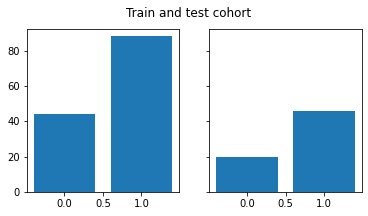

In [199]:
labels, counts = np.unique(y_train, return_counts=True)
zip_iterator = zip(labels, counts)
train_data = dict(zip_iterator)

train_names = list(train_data.keys())
train_values = list(train_data.values())

labels, counts = np.unique(y_test, return_counts=True)
zip_iterator = zip(labels, counts)
test_data = dict(zip_iterator)

test_names = list(test_data.keys())
test_values = list(test_data.values())

ER_type = {'0': 'Non ER', '1': 'ER'}

fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
axs[0].bar(names, values, label=ER_type[str(labels[0])])
axs[1].bar(test_names, test_values, label=ER_type[str(labels[1])])

fig.suptitle('Train and test cohort')


In [273]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score

def prediction(model, X_test, y_test, model_name):
    
    result = {}

    y_true = y_test
    y_score = model.predict_proba(X_test)
    predited = model.predict(X = X_test)

    # Calcul du perf
    cm = confusion_matrix(y_test, predited)
    TN = cm[0, 0]
    FN = cm[1, 0]
    TP = cm[1, 1]
    FP = cm[0, 1]

    y_true = y_test

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    precision = TP / (TP + FP)
    F1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    
    fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    
    
    result = {'model':model_name ,'accuracy':accuracy, 'roc_auc':roc_auc, 'sensitivity':sensitivity, 'specificity':specificity,'F1':F1} 

    return result

def confus_matrix_labels(cm):
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    return labels


In [362]:
df_result = pd.DataFrame()

In [363]:
# LR

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear',class_weight ='balanced')
logreg.fit(X_train, y_train)

log_score = prediction(logreg, X_test, y_test, 'logreg')
df_result = df_result.append(log_score, ignore_index=True)

predited = logreg.predict(X = X_test)
cm_lr = confusion_matrix(y_test, predited)

In [364]:
# SVM

from sklearn import svm

svm =  svm.SVC(probability=True, class_weight ='balanced')
svm.fit(X_train, y_train)

svm_score = prediction(svm, X_test, y_test, 'SVM')
#df_result = df_result.append(svm_score, ignore_index=True)

predited = svm.predict(X = X_test)
cm_svm = confusion_matrix(y_test, predited)

In [365]:
# Gxboost
from sklearn.ensemble import GradientBoostingClassifier

gx = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=3, random_state=42)
gx.fit(X_train, y_train)

gx_score = prediction(gx, X_test, y_test, 'gx')
df_result = df_result.append(gx_score, ignore_index=True)

predited = gx.predict(X = X_test)
cm_gx = confusion_matrix(y_test, predited)


In [366]:
# rf

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=4, class_weight ='balanced')
rf.fit(X_train, y_train)

rf_score = prediction(rf, X_test, y_test,'RandomForestClassifier')
df_result = df_result.append(rf_score, ignore_index=True)

predited = rf.predict(X = X_test)
cm_rf = confusion_matrix(y_test, predited)

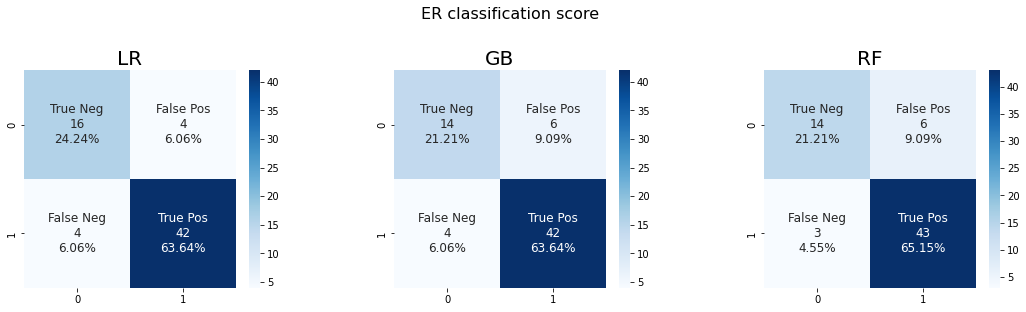

model  accuracy   roc_auc  sensitivity  specificity  \
0                  logreg  0.878788  0.884783     0.913043          0.8   
1                      gx  0.848485  0.877174     0.913043          0.7   
2  RandomForestClassifier  0.863636  0.916304     0.934783          0.7   

         F1  
0  0.913043  
1  0.893617  
2  0.905263

In [367]:
fig = plt.figure(figsize=(18,4))

ax1 = plt.subplot(1, 3, 1)
sns.heatmap(cm_lr, annot=confus_matrix_labels(cm_lr), fmt="", cmap='Blues', annot_kws={"size": 12}, ax = ax1)
ax1.set_title('LR', fontsize = 20)

#ax2 = plt.subplot(1, 3, 2)
#sns.heatmap(cm_svm, annot=confus_matrix_labels(cm_svm), fmt="", cmap='Blues', annot_kws={"size": 12}, ax = ax2)
#ax2.set_title('SVM', fontsize = 20)

ax2 = plt.subplot(1, 3, 2)
sns.heatmap(cm_gx, annot=confus_matrix_labels(cm_gx), fmt="", cmap='Blues', annot_kws={"size": 12}, ax = ax2)
ax2.set_title('GB', fontsize = 20)

ax3 = plt.subplot(1, 3, 3)
sns.heatmap(cm_rf, annot=confus_matrix_labels(cm_rf), fmt="", cmap='Blues', annot_kws={"size": 12}, ax = ax3)
ax3.set_title('RF', fontsize = 20)

fig.suptitle("ER classification score", fontsize=16, y=1.1)
plt.subplots_adjust(wspace=0.4)
plt.show()

df_result

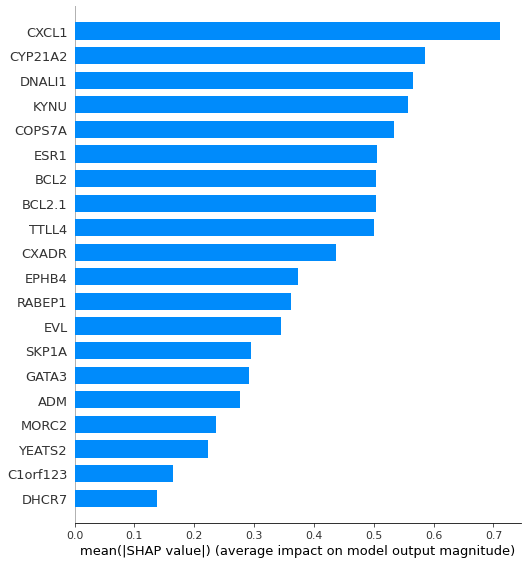

In [368]:
# LG
explainer = shap.LinearExplainer(logreg, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_train, plot_type="bar")

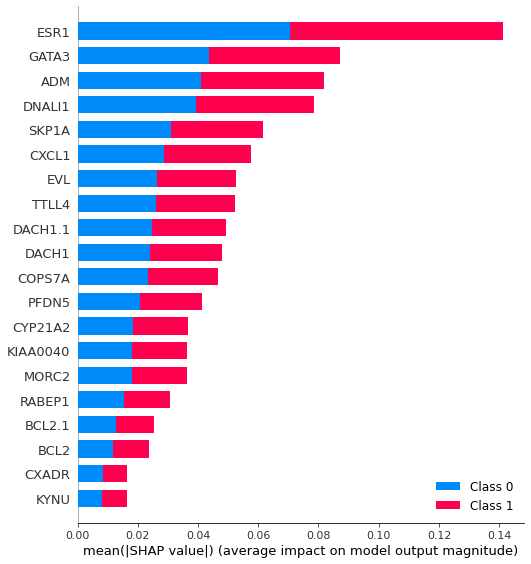

In [371]:
# RF
shap_values = shap.Explainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

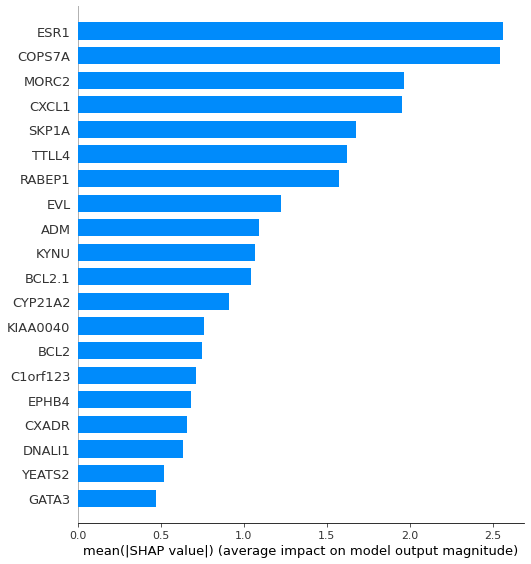

In [370]:
# GX
explainer = shap.Explainer(gx)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")